<a href="https://colab.research.google.com/github/jafarbakhshaliyev/Credit-Risk-Modeling/blob/main/Credit_Risk_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Modeling:

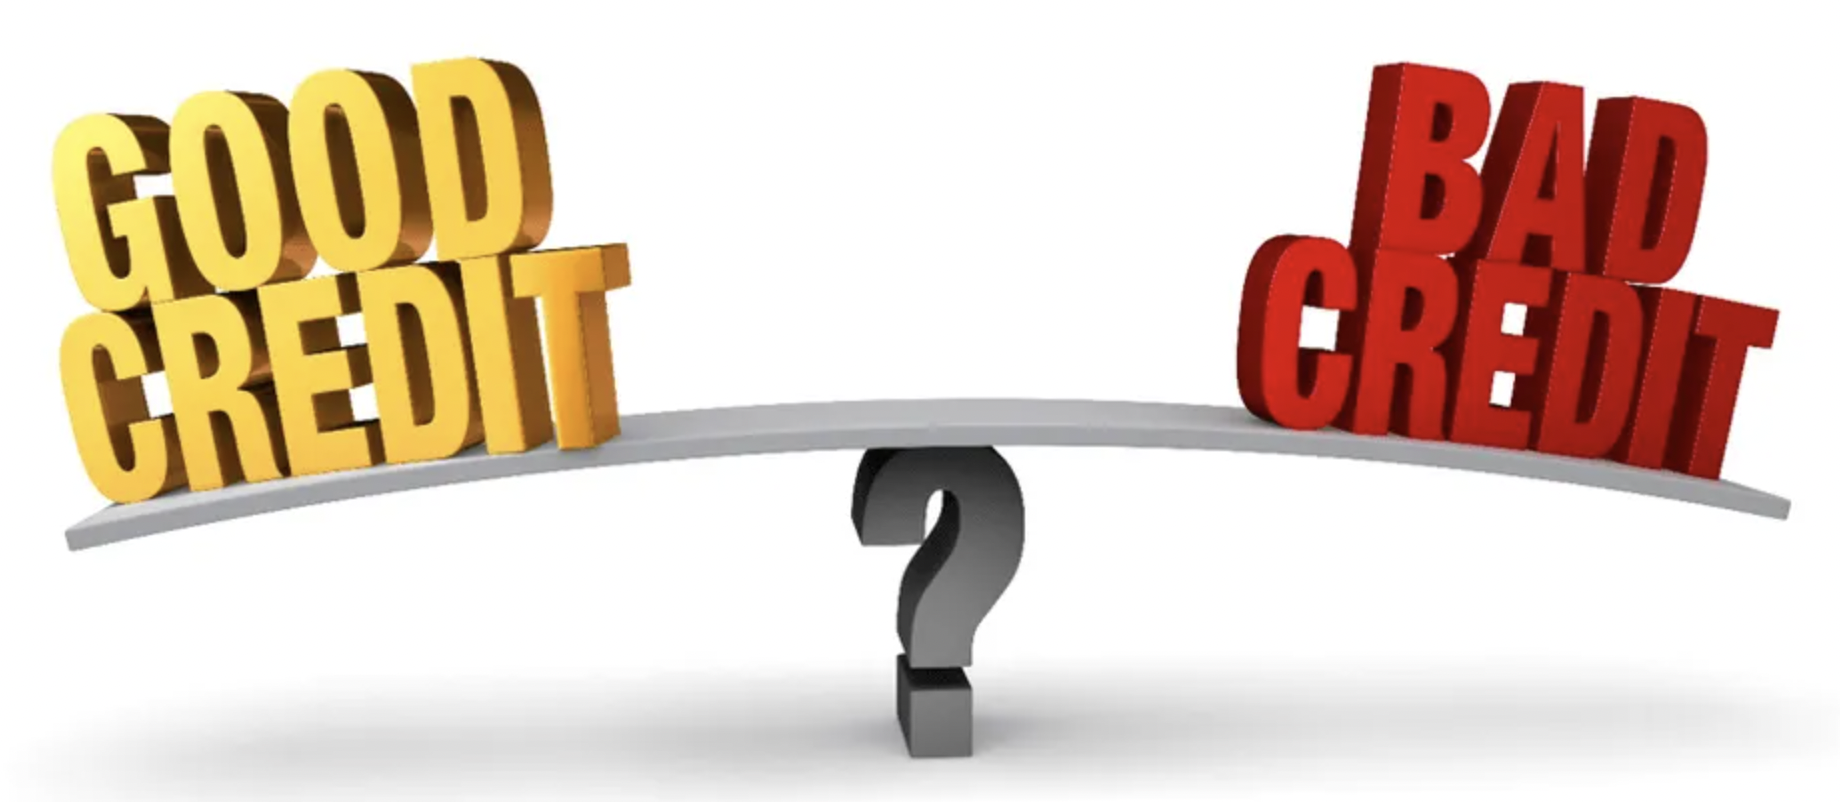

# Importing Modules:


**Importing packages:**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, precision_score, recall_score, precision_recall_curve, make_scorer, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
#pip install catboost
#from catboost import CatBoostClassifier

import shap

from mlxtend.plotting import plot_decision_regions

In [4]:
np.random.seed(0)
import tensorflow as tf
from tensorflow.keras.layers import InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.embeddings import Embedding
from keras import optimizers

**Functions for doing GridSearch, creating dataframe for predicted probabilties by scaling back to original size, developing confusion matrix, and doing swap set analysis:**

In [6]:
def gridsearch(model,param_grids,X,y,cv = 5):
  # find the best parameter   
  k_fold = KFold(n_splits=cv)
  grid_search = GridSearchCV(model, param_grids, scoring='roc_auc', n_jobs=-1, cv=kfold)
  grid_result = grid_search.fit(X, y)
  print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')
  score = grid_result.best_score_
  params = grid_result.best_params_
  return (params,score)
def create_dataframe(model,X,y, weight0=1, weight1=1,scale=False, neural = False):
  if neural == True:
    predicted_train = model.predict(X)
    predicted_train = pd.DataFrame(predicted_train, columns = ['Column_B'])
    predicted_train['Column_A'] = 1 - predicted_train['Column_B'] 
  else:
    predicted_train = model.predict_proba(X)
    predicted_train = pd.DataFrame(predicted_train, columns = ['Column_A','Column_B'])
  if scale == True:
    predicted_train['Column_A']=predicted_train['Column_A']/weight0
    predicted_train['Column_B']=predicted_train['Column_B']/weight1
    predicted_train['Total'] = predicted_train['Column_A'] + predicted_train['Column_B']
    predicted_train['Column_C'] = predicted_train['Column_B']/predicted_train['Total']
    prediction_train = predicted_train['Column_C']
  else:
    prediction_train = predicted_train['Column_B']
  y_values_train = pd.DataFrame(y.values, columns = ['Column_A'])
  df = pd.DataFrame()
  df['bad'] = y_values_train
  df['model_predicted_probability'] = prediction_train
  return df
def confusionmatrix(model,X,y, neural = False):
  if neural == True:
    y_pred_proba = model.predict(X)
    y_pred= (model.predict(X) > 0.5).astype("int32")
  else:
    y_pred_proba = model.predict_proba(X)
    y_pred = model.predict(X)
  fig, ax = plt.subplots()
  sns.heatmap(confusion_matrix(y, y_pred,normalize='true'), annot=True, ax=ax)
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Value')
  ax.set_ylabel('Real Value')
  if neural == True:
    print(pd.DataFrame([roc_auc_score(y, y_pred),roc_auc_score(y, y_pred_proba[:,0])],index=['ROC-AUC','ROC-AUC as Prob']).transpose())
  else:
    print(pd.DataFrame([roc_auc_score(y, y_pred),roc_auc_score(y, y_pred_proba[:,1])],index=['ROC-AUC','ROC-AUC as Prob']).transpose())
  return y_pred
def scorecard(model1,model2,X,y):
  df1 = model1.predict(X)
  df2 = model2.predict(X)
  df = pd.DataFrame(data=y,columns=['bad']); df['model1_pred'] = df1; df['model2_pred'] = df2
  df['model_2_swap_in'] = (df['model2_pred'] == df['bad']) & (df['model1_pred'] != df['bad'])
  df['model_2_swap_out'] = (df['model2_pred'] != df['bad']) & (df['model1_pred'] == df['bad'])
  df['model_2_swap_in_positive'] = ((df['model2_pred']==df['bad']) & (df['model1_pred']!= df['bad']) & (df['bad']==1) )
  df['model_2_swap_in_negative'] = ((df['model2_pred']==df['bad']) & (df['model1_pred']!= df['bad']) & (df['bad']==0) )
  df['model_2_swap_out_positive'] = ((df['model2_pred']!=df['bad']) & (df['model1_pred']== df['bad']) & (df['bad']==1) )
  df['model_2_swap_out_negative'] = ((df['model2_pred']!=df['bad']) & (df['model1_pred']== df['bad']) & (df['bad']==0) )
  df['approved'] = ((df['model2_pred']==0) & (df['model1_pred']==0))
  df['declined'] = ((df['model2_pred']==1) & (df['model1_pred']==1))
  df['AD'] = ((df['model2_pred']==1) & (df['model1_pred']==0))
  df['DA'] = ((df['model2_pred']==0) & (df['model1_pred']==1))
  print('------------------------------------------------------------------')
  print('Swap-IN Size:',df[df['model_2_swap_in']].shape[0])
  print('Swap-OUT Size',df[df['model_2_swap_out']].shape[0])
  print('Swap IN / Swap OUT:',df[df['model_2_swap_in']].shape[0]/df[df['model_2_swap_out']].shape[0])
  print('Swap OUT / Swap IN:',df[df['model_2_swap_out']].shape[0]/df[df['model_2_swap_in']].shape[0])
  print('------------------------------------------------------------------')
  print('Swap-IN-Positive:',df[df['model_2_swap_in_positive']].shape[0])
  print('Swap-IN-Negative:',df[df['model_2_swap_in_negative']].shape[0])
  print('Swap-OUT-Positive:',df[df['model_2_swap_out_positive']].shape[0])
  print('Swap-OUT-Negative:',df[df['model_2_swap_out_negative']].shape[0])
  print('------------------------------------------------------------------')
  print("Approved by Both:",df[df['approved']].shape[0])
  print("Declined by Both:",df[df['declined']].shape[0])
  print("Approved by First, Declined By Second:",df[df['AD']].shape[0])
  print("Declined by First, Approved By Second:",df[df['DA']].shape[0])

  return df

# Exploratory Data Analysis (EDA):

In [7]:
# accessing to the data
data_cleaned = pd.read_csv('MAXD_UTD_MODELDEVELOPMENT_DATA.csv')
#dropping some repeated features
data_cleaned.drop(['m_bba_p_A05','m_bba_p_A06','m_bba_p_B38'], axis=1, inplace=True) 

In [8]:
# see first 5 rows and all columns
data_cleaned.head()

app_id  bad  m_inq_date_of_last_activity  m_CCRS_ALL_dd_7_years_ago  \
0   16269    0                            1                          0   
1   16270    0                            1                          0   
2   16271    0                            0                          1   
3   16272    0                            0                          0   
4   16273    0                            1                          1   

   m_ccr_days_since_last_ontime_pmt  m_ccr_days_since_last_loan_pmt  \
0                                 1                               1   
1                                 1                               1   
2                                 1                               1   
3                                 1                               1   
4                                 0                               0   

   m_inq_net_monthly_income  m_bba_p_d_since_validated_trade  \
0                         0                         0.228023   
1                         0                         0.088674   
2                         0                         0.228023   
3                         0                        -0.080440   
4                         0                         0.228023   

   m_bba_p_default_history  m_cbb_A05  ...  m_ccrea_bcx7110  m_ccrea_brc7140  \
0                 0.262892          1  ...        -0.080840         0.154884   
1                -0.225760          1  ...        -0.088520        -0.129000   
2                -0.225760          1  ...        -0.080840        -0.211390   
3                -0.096340          0  ...         0.182567         0.154884   
4                 0.262892          1  ...         0.182567         0.154884   

   m_ccrea_brc7160  m_ccrea_iln7150  m_bba_p_account_age_code  \
0         0.149725        -0.187540                         0   
1         0.149725         0.073789                         0   
2        -0.325230         0.073789                         0   
3         0.149725         0.073789                         1   
4         0.149725         0.073789                         0   

   m_bba_p_validated_through_trades  m_ccr_worst_payment_rating  \
0                                 1                           0   
1                                 1                           0   
2                                 1                           0   
3                                 0                           0   
4                                 1                           0   

   m_ccrea_aua6280  m_ccrea_bcc6160  m_ccrea_iln6230  
0        -0.252640        -0.088770        -0.145330  
1         0.058109         0.012685         0.136701  
2         0.043854        -0.088770        -0.145330  
3         0.125723         0.153668         0.136701  
4         0.125723         0.153668        -0.145330  

[5 rows x 285 columns]

In [9]:
# data frame shape
print('Number of rows: ', data_cleaned.shape[0])
print('Number of columns: ', data_cleaned.shape[1])

Number of rows:  6358
Number of columns:  285


In [10]:
# data frame summary
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Columns: 285 entries, app_id to m_ccrea_iln6230
dtypes: float64(45), int64(240)
memory usage: 13.8 MB


In [11]:
# percentage of missing values per feature
print((data_cleaned.isnull().sum() * 100 / data_cleaned.shape[0]).sort_values(ascending=False))

app_id                         0.0
m_ccrea_rev0300                0.0
m_caaea_all2000                0.0
m_caaea_all1380                0.0
m_caaea_rev1300                0.0
                              ... 
m_CCRS_ALL_dd_60_days_ago      0.0
m_CCRS_ALL_dd_90_days_ago      0.0
m_CCRS_ALL_dlp_180_days_ago    0.0
m_CCRS_ALL_dlp_2_years_ago     0.0
m_ccrea_iln6230                0.0
Length: 285, dtype: float64


In [12]:
# number of unique observations per column
data_cleaned.nunique().sort_values()

m_CCRS_C3_dd_15_days_ago         2
m_CCRS_ALL_alp_2_years_ago       2
m_CCRS_ALL_alp_1_year_ago        2
m_CCRS_ALL_acl_3_years_ago       2
m_ccrea_col3210                  2
                              ... 
m_CCRS_ALL_ato_3_years_ago    2299
m_ccr_amount_of_loans         2609
m_CCRS_ALL_ato_7_years_ago    2609
m_caaea_col5060               3404
app_id                        6358
Length: 285, dtype: int64

In [13]:
# show descriptive statistics
data_cleaned.describe()

app_id          bad  m_inq_date_of_last_activity  \
count   6358.000000  6358.000000                  6358.000000   
mean   19447.500000     0.175841                     0.451714   
std     1835.540838     0.380715                     0.497702   
min    16269.000000     0.000000                     0.000000   
25%    17858.250000     0.000000                     0.000000   
50%    19447.500000     0.000000                     0.000000   
75%    21036.750000     0.000000                     1.000000   
max    22626.000000     1.000000                     1.000000   

       m_CCRS_ALL_dd_7_years_ago  m_ccr_days_since_last_ontime_pmt  \
count                6358.000000                       6358.000000   
mean                    0.678358                          0.350897   
std                     0.467143                          0.477288   
min                     0.000000                          0.000000   
25%                     0.000000                          0.000000   
50%                     1.000000                          0.000000   
75%                     1.000000                          1.000000   
max                     1.000000                          1.000000   

       m_ccr_days_since_last_loan_pmt  m_inq_net_monthly_income  \
count                     6358.000000               6358.000000   
mean                         0.393835                  0.100503   
std                          0.488637                  0.300694   
min                          0.000000                  0.000000   
25%                          0.000000                  0.000000   
50%                          0.000000                  0.000000   
75%                          1.000000                  0.000000   
max                          1.000000                  1.000000   

       m_bba_p_d_since_validated_trade  m_bba_p_default_history    m_cbb_A05  \
count                      6358.000000              6358.000000  6358.000000   
mean                          0.005497                 0.011570     0.348695   
std                           0.121808                 0.177767     0.476595   
min                          -0.080440                -0.225760     0.000000   
25%                          -0.080440                -0.096340     0.000000   
50%                          -0.080440                -0.096340     0.000000   
75%                           0.088674                 0.262892     1.000000   
max                           0.228023                 0.262892     1.000000   

       ...  m_ccrea_bcx7110  m_ccrea_brc7140  m_ccrea_brc7160  \
count  ...      6358.000000      6358.000000      6358.000000   
mean   ...         0.010985         0.009910         0.009410   
std    ...         0.173987         0.164324         0.165128   
min    ...        -0.321040        -0.451210        -0.451210   
25%    ...        -0.153330        -0.129000        -0.113510   
50%    ...        -0.080840         0.154884         0.149725   
75%    ...         0.182567         0.154884         0.149725   
max    ...         0.182567         0.154884         0.149725   

       m_ccrea_iln7150  m_bba_p_account_age_code  \
count      6358.000000               6358.000000   
mean          0.003508                  0.370714   
std           0.106795                  0.483034   
min          -0.187540                  0.000000   
25%          -0.093120                  0.000000   
50%           0.073789                  0.000000   
75%           0.073789                  1.000000   
max           0.073789                  1.000000   

       m_bba_p_validated_through_trades  m_ccr_worst_payment_rating  \
count                       6358.000000                 6358.000000   
mean                           0.360805                    0.271469   
std                            0.480272                    0.444752   
min                            0.000000                    0.000000   
25%                            0.000000                    0.

In [14]:
# getting data and target values separately
X = data_cleaned.drop(['bad','app_id'], axis=1)
y = data_cleaned['bad']

In [15]:
print('Number of rows and columns of data:', X.shape)
print('Number of rows and columns of target: ',y.shape)

Number of rows and columns of data: (6358, 283)
Number of rows and columns of target:  (6358,)


In [16]:
print('Number of good debtor in the target: ', y[y==0].count())
print('Number of bad debtor in the target: ', y[y==1].count())

Number of good debtor in the target:  5240
Number of bad debtor in the target:  1118


In [17]:
# ratio of number of bad debtor to number of good debtor -- we generally use it for class weight if we need
1118/5240

0.2133587786259542

# Data Preprocessing:

In [18]:
# splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.23, random_state = 0)

In [19]:
print('Number of rows and columns of train data: ', X_train.shape)
print('Number of rows and columns of train target: ', y_train.shape)
print('Number of rows and columns of test data: ', X_test.shape)
print('Number of rows and columns of test target: ', y_test.shape)

Number of rows and columns of train data:  (4895, 283)
Number of rows and columns of train target:  (4895,)
Number of rows and columns of test data:  (1463, 283)
Number of rows and columns of test target:  (1463,)


In [20]:
# finding variance of the features and scale according to high variances (non-categorical variables)
X_train = pd.DataFrame(X_train)
df = X_train.var()
print(df.to_string())
cols_to_norm = ['m_ccrea_all7936','m_caaea_all8325','m_ccrea_all7360','m_caaea_all7340','m_ccrea_all7936' ,'m_CCRS_C3_inq_180_days_ago','m_CCRS_ALL_dd_60_days_ago','m_CAAS_ALL_ato_7_days_ago','m_bba_p_d_since_first_seen_by_c','m_caaea_col5060','m_CAAS_ALL_ato_24_hours_ago','m_ccr_amt_of_loans_paid_off','m_ccr_amount_of_loans','m_ccr_days_since_1st_loan_opened','m_ccr_d_since_1st_bank_acct_pre','m_ccr_d_since_last_loan_paidoff','m_ccr_days_since_1st_ontime_pmt','m_ccr_d_since_previous_ban_0001','m_ccr_d_since_previous_bankacct','m_ccr_d_since_reported_income_p','m_CCRS_ALL_ato_1_year_ago','m_CCRS_ALL_ato_180_days_ago','m_CCRS_ALL_ato_2_years_ago','m_CCRS_ALL_ato_3_years_ago','m_CCRS_ALL_ato_30_days_ago','m_CCRS_ALL_ato_60_days_ago','m_CCRS_ALL_ato_7_years_ago','m_CCRS_ALL_dd_1_year_ago','m_CCRS_ALL_dd_180_days_ago','m_CCRS_ALL_dd_2_years_ago','m_CCRS_ALL_dd_3_years_ago','m_CCRS_ALL_dd_90_days_ago','m_CCRS_ALL_dlp_3_years_ago','m_CCRS_C1_ato_7_years_ago','m_CCRS_C3_ato_1_year_ago','m_CCRS_C3_ato_15_days_ago','m_CCRS_C3_ato_180_days_ago','m_CCRS_C3_ato_2_years_ago','m_CCRS_C3_ato_3_years_ago','m_CCRS_C3_ato_30_days_ago','m_CCRS_C3_ato_60_days_ago','m_CCRS_C3_ato_7_years_ago','m_CCRS_C3_ato_90_days_ago','m_CCRS_C3_dd_1_year_ago','m_CCRS_C3_dd_180_days_ago','m_CCRS_C3_dd_2_years_ago','m_CCRS_C3_dd_3_years_ago','m_CCRS_C3_dd_7_years_ago','m_CCRS_C3_dd_90_days_ago','m_caaea_all5360','m_caaea_all5070']

m_inq_date_of_last_activity         2.478140e-01
m_CCRS_ALL_dd_7_years_ago           2.162768e-01
m_ccr_days_since_last_ontime_pmt    2.272852e-01
m_ccr_days_since_last_loan_pmt      2.385238e-01
m_inq_net_monthly_income            8.928195e-02
m_bba_p_d_since_validated_trade     1.475478e-02
m_bba_p_default_history             3.177930e-02
m_cbb_A05                           2.281402e-01
m_cbb_A06                           1.978289e-01
m_cbb_B04                           1.427210e-01
m_cbb_B38                           2.039856e-01
m_ccr_cd_10                         2.487945e-01
m_ccr_cd_29                         2.227649e-01
m_ccr_cd_32                         2.104099e-01
m_ccr_cd_33                         2.199981e-01
m_ccr_cd_37                         2.211209e-01
m_ccr_cd_cnt                        4.397775e-01
m_bba_p_d_since_first_seen_by_c     2.235025e+05
m_bba_p_d_since_last_seen_by_cl     2.500300e-01
m_bba_p_default_rate_60_days_ago    1.232282e+01
m_bba_p_default_rate

In [21]:
# scaling data (non-categorical variables)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [22]:
# Random oversampling method
oversample = RandomOverSampler(random_state = 0)
X_train_os, y_train_os = oversample.fit_resample(X_train_scaled, y_train)

# SMOTE oversampling method
#oversample = SMOTE()
#X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

# SMOTE ENN Method
# enn = SMOTEENN()
# X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)



In [23]:
print('Number of good debtor in the target: ', y_train[y_train==0].count())
print('Number of bad debtor in the target: ', y_train[y_train==1].count())

Number of good debtor in the target:  4034
Number of bad debtor in the target:  861


In [24]:
print('Number of good debtor in the target: ', y_train_os[y_train_os==0].count())
print('Number of bad debtor in the target: ', y_train_os[y_train_os==1].count())

Number of good debtor in the target:  4034
Number of bad debtor in the target:  4034


# XGBoost (Extreme Gradient Boosting):

## GridSearch




In [25]:
'''
xgb = XGBClassifier(objective = 'binary:logistic',n_estimators=1500,min_child_weight=1,subsample = 0.10, colsample_bytree = 0.25)
param_grid = {'max_depth': [1, 2, 3, 4],
              'gamma': [0, 1, 2, 3, 4],
              'reg_alpha': [1, 3, 5, 10, 15],
              'learning_rate': [0.0001, 0.005, 0.050,0.075, 0.1]}
gridsearch(xgb,param_grid,X_train_os,y_train_os,cv = 8)
'''              

"\nxgb = XGBClassifier(objective = 'binary:logistic',n_estimators=1500,min_child_weight=1,subsample = 0.10, colsample_bytree = 0.25)\nparam_grid = {'max_depth': [1, 2, 3, 4],\n              'gamma': [0, 1, 2, 3, 4],\n              'reg_alpha': [1, 3, 5, 10, 15],\n              'learning_rate': [0.0001, 0.005, 0.050,0.075, 0.1]}\ngridsearch(xgb,param_grid,X_train_os,y_train_os,cv = 8)\n"

## Final Model & Results



In [26]:
# final XGB model
xgb = XGBClassifier(objective = 'binary:logistic',n_estimators=1500, max_depth=4, min_child_weight=1,subsample = 0.10, colsample_bytree = 0.25,learning_rate = 0.004,gamma = 1.8, reg_alpha = 10)
xgb.fit(X_train_os,y_train_os)

XGBClassifier(colsample_bytree=0.25, gamma=1.8, learning_rate=0.004,
              max_depth=4, n_estimators=1500, reg_alpha=10, subsample=0.1)

**Recursive Elimination Procedure:**


In [27]:
"""
# fit model on all training data
model = XGBClassifier(objective = 'binary:logistic',n_estimators=1500) 
model.fit(X_train_os, y_train_os)
# make predictions for test data and evaluate
predictions = model.predict(X_test_scaled)
accuracy = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds =  np.sort(model.feature_importances_)[10:]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train_os)
	# train model
	selection_model = xgb #with parameters
	selection_model.fit(select_X_train, y_train_os)
	# eval model
	select_X_test = selection.transform(X_test_scaled)
	predictions = selection_model.predict(select_X_test)
	accuracy = roc_auc_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	"""

'\n# fit model on all training data\nmodel = XGBClassifier(objective = \'binary:logistic\',n_estimators=1500) \nmodel.fit(X_train_os, y_train_os)\n# make predictions for test data and evaluate\npredictions = model.predict(X_test_scaled)\naccuracy = roc_auc_score(y_test, predictions)\nprint("Accuracy: %.2f%%" % (accuracy * 100.0))\n# Fit model using each importance as a threshold\nthresholds =  np.sort(model.feature_importances_)[10:]\nfor thresh in thresholds:\n\t# select features using threshold\n\tselection = SelectFromModel(model, threshold=thresh, prefit=True)\n\tselect_X_train = selection.transform(X_train_os)\n\t# train model\n\tselection_model = xgb #with parameters\n\tselection_model.fit(select_X_train, y_train_os)\n\t# eval model\n\tselect_X_test = selection.transform(X_test_scaled)\n\tpredictions = selection_model.predict(select_X_test)\n\taccuracy = roc_auc_score(y_test, predictions)\n\tprint("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*

**I chose threshold value as 0.00298317 based on recursive elmination above that takes 164 important features:**

In [28]:
# fit model on all training data
model = XGBClassifier(objective = 'binary:logistic',n_estimators=1500)
model.fit(X_train_os, y_train_os)
# make predictions for test data and evaluate
predictions = model.predict(X_test_scaled)
accuracy = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds =  np.sort(model.feature_importances_)[89:]
# select features using threshold
selection = SelectFromModel(model, threshold=0.00298317 , prefit=True)
select_X_train = selection.transform(X_train_os)
# train model
selection_model = xgb
selection_model.fit(select_X_train, y_train_os)
# eval model
select_X_test = selection.transform(X_test_scaled)
predictions = selection_model.predict(select_X_test)
accuracy = roc_auc_score(y_test, predictions)
select_X = selection.transform(X_train_scaled)
print("n=%d, Accuracy: %.2f%%" % ( select_X_train.shape[1], accuracy*100.0))


Accuracy: 53.24%


X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


n=164, Accuracy: 61.29%


X has feature names, but SelectFromModel was fitted without feature names


**DataFrames of predicted probabilities for train and test dataset:**

In [29]:
XGB_train = create_dataframe(xgb,select_X,y_train,1,4.685249,scale=True)
XGB_test = create_dataframe(xgb,select_X_test,y_test,1,4.685249,scale=True)

**Developing Rank Order Tables:**

roc:  0.72268
total_wgt:  4895
total_bad_rate:  0.175893769
KS:  34.4282


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


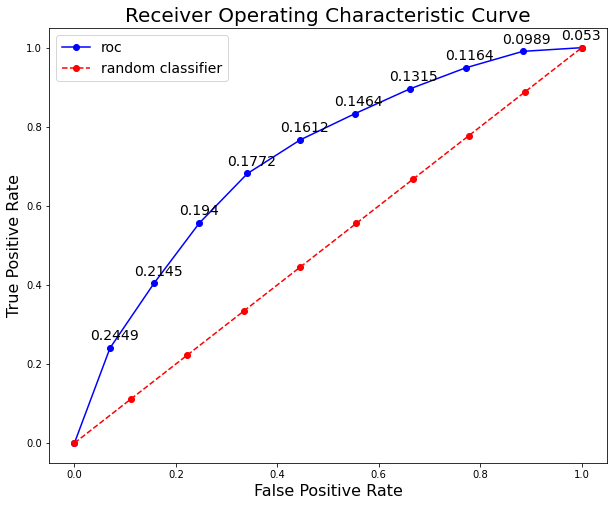

-----------------------------------------------------------------------------------------
------------------------------------TEST-------------------------------------------------
-----------------------------------------------------------------------------------------
roc:  0.64641
total_wgt:  1463
total_bad_rate:  0.175666439
KS:  24.4268


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


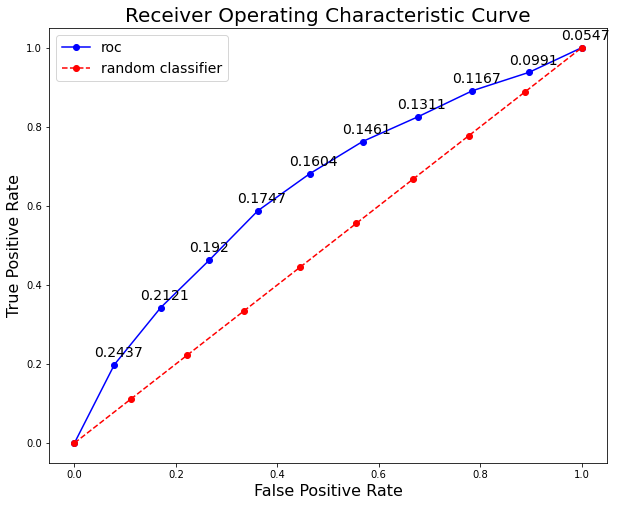

In [30]:
out_XGB_train=calculate_metrics(XGB_train,'bad',1,'model_predicted_probability',10,False)
print('-----------------------------------------------------------------------------------------')
print('------------------------------------TEST-------------------------------------------------')
print('-----------------------------------------------------------------------------------------')
out_XGB_test=calculate_metrics(XGB_test,'bad',1,'model_predicted_probability',10,False)

**Confusion Matrixes:**

    ROC-AUC  ROC-AUC as Prob
0  0.670059         0.722675
    ROC-AUC  ROC-AUC as Prob
0  0.612852         0.646414


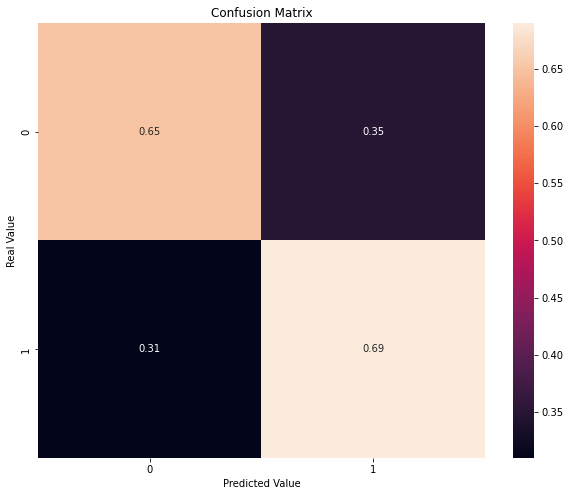

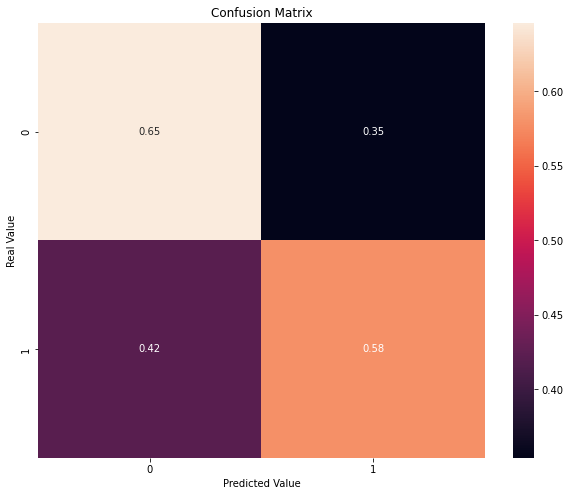

In [31]:
xgb_pred_train = confusionmatrix(xgb, select_X, y_train)
xgb_pred_test = confusionmatrix(xgb, select_X_test, y_test)

## Validation

In [32]:
# accessing to the data
new_data = pd.read_csv('MAXD_UTD_MODELVALIDATION_DATA.csv')
#dropping some columns which repeated
new_data.drop(['m_bba_p_A05','m_bba_p_A06','m_bba_p_B38'], axis=1, inplace=True)
# getting data and target values separately
X_val = new_data.drop(['bad','app_id'], axis=1)
y_val = new_data['bad']
print('Number of good debtor in the target: ', y_val[y_val==0].count())
print('Number of bad debtor in the target: ', y_val[y_val==1].count())

Number of good debtor in the target:  1456
Number of bad debtor in the target:  320


In [33]:
X_val_scaled = X_val.copy()
X_val_scaled[cols_to_norm] = scaler.transform(X_val[cols_to_norm])
select_X_val_scaled = selection.transform(X_val_scaled)

X has feature names, but SelectFromModel was fitted without feature names


In [34]:
XGB_val = create_dataframe(xgb,select_X_val_scaled,y_val,1,4.685249,scale=True)

roc:  0.62571
total_wgt:  1776
total_bad_rate:  0.18018018
KS:  21.5625


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


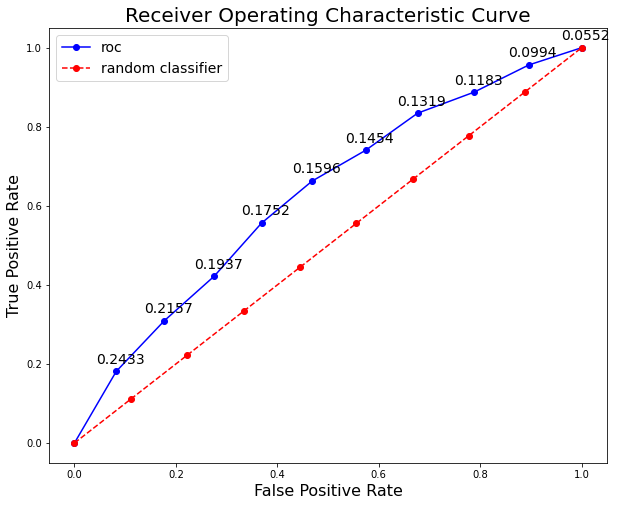

In [35]:
out_XGB_val=calculate_metrics(XGB_val,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.590058         0.625714


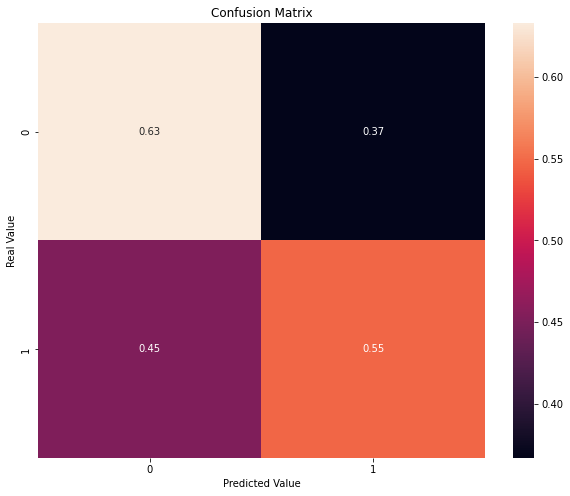

In [36]:
xgb_pred_val = confusionmatrix(xgb,select_X_val_scaled,y_val)

## Analyzing Features

**Shap Analysis on Features:**

In [37]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(select_X_train)

In [38]:
col_index = selection.get_support()
features_index = X_train_os.columns[col_index]

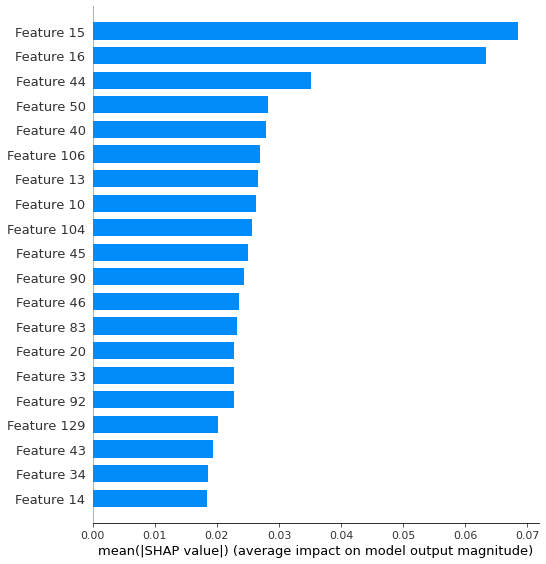

In [39]:
shap.summary_plot(shap_values, select_X_train, max_display=20, plot_type="bar")

In [40]:
print(features_index[15]) # Returns the percentage of tradelines that defaulted for the routing number in the last 60 days. (+)
print(features_index[16]) # Returns the percentage of tradelines that defaulted for the routing number in the last 61-365 days. (+)
print(features_index[44]) # Number of days since first on-time payment on a loan was made. (-)
print(features_index[50]) # Total number of employers reported in the last six months. (+) (categorical)
print(features_index[40]) # Total dollar amount of paid off loans. (-)
print(features_index[106]) # Total credit amount on unsatisfied derogatory trades including collections. (+)
print(features_index[13]) # Returns the number of days since Clarity first received the bank account on an inquiry. (-)
print(features_index[10]) # Insufficient recent online payday loan activity. (-) (categorical)
print(features_index[104]) # Total number of trades opened in the last 12 months ever 30 or more days delinquent or derogatory excluding collections. (+) (categorical)
print(features_index[45]) # Number of days since last paid off loan. (+)
print(features_index[90]) # Total number of Online Installment inquiries in the last 180 days. (+) (days small)
print(features_index[46]) # Number of days since the previous/newest bank account was first by Clarity. (-) (days big)
print(features_index[83]) # Number of days with one or more Online Installment loans in the last 2 years. (-) (days big)
print(features_index[20]) # Total number of inquiries made in the last 3 months (no deduplication). (+) (categorical)
print(features_index[33]) # Total number of non-traditional inquiries clusters in the last 90 days. (+) (days small)
print(features_index[92]) # Total number of Online Installment inquiries in the last 90 days. (+) (days small)
print(features_index[129]) # Total balance on trades presently derogatory occurred in the last 6 months including collections. (+) (big numbers)
print(features_index[43]) # Number of days since the first loan was opened. (-) (very big days)
print(features_index[34]) # Total number of non-traditional inquiries seen in the last 2 years. (+) (categorical)
print(features_index[14]) # Returns the number of days since Clarity last received the bank account on an inquiry. (-) (categorical)

m_bba_p_default_rate_60_days_ago
m_bba_p_default_rate_61_365_d_a
m_ccr_days_since_1st_ontime_pmt
m_ccr_num_of_employ_last_6_mon
m_ccr_amt_of_loans_paid_off
m_caaea_all5360
m_bba_p_d_since_first_seen_by_c
m_ccr_cd_33
m_caaea_all2427
m_ccr_d_since_last_loan_paidoff
m_CCRS_C3_inq_180_days_ago
m_ccr_d_since_previous_bankacct
m_CCRS_C3_dd_2_years_ago
m_caaea_iqt9425
m_CAAS_CA_clu_90_days_ago
m_CCRS_C3_inq_90_days_ago
m_caaea_all5070
m_ccr_days_since_1st_loan_opened
m_CAAS_CA_inq_2_years_ago
m_bba_p_d_since_last_seen_by_cl


In [41]:
X_train[['m_bba_p_default_rate_60_days_ago','m_bba_p_default_rate_61_365_d_a','m_ccr_days_since_1st_ontime_pmt','m_ccr_num_of_employ_last_6_mon','m_ccr_amt_of_loans_paid_off','m_caaea_all5360','m_bba_p_d_since_first_seen_by_c','m_ccr_cd_33','m_caaea_all2427','m_ccr_d_since_last_loan_paidoff','m_CCRS_C3_inq_180_days_ago','m_ccr_d_since_previous_bankacct','m_CCRS_C3_dd_2_years_ago','m_caaea_iqt9425','m_CAAS_CA_clu_90_days_ago','m_CCRS_C3_inq_90_days_ago','m_caaea_all5070','m_ccr_days_since_1st_loan_opened','m_CAAS_CA_inq_2_years_ago','m_bba_p_d_since_last_seen_by_cl']]

m_bba_p_default_rate_60_days_ago  m_bba_p_default_rate_61_365_d_a  \
5786                              5.10                             7.16   
4253                              7.62                             8.46   
812                               8.20                             8.24   
1809                              8.61                            10.20   
5609                              6.57                            12.24   
...                                ...                              ...   
6172                             15.37                            14.85   
6073                              5.38                             5.94   
3979                              1.65                             5.19   
1938                              2.86                            25.86   
5318                              6.59                             7.72   

      m_ccr_days_since_1st_ontime_pmt  m_ccr_num_of_employ_last_6_mon  \
5786                             2301                               1   
4253                              229                               2   
812                                 0                               2   
1809                                0                               1   
5609                              635                               1   
...                               ...                             ...   
6172                                0                               1   
6073                             1123                               4   
3979                                0                               1   
1938                             1078                               1   
5318                             1428                               3   

      m_ccr_amt_of_loans_paid_off  m_caaea_all5360  \
5786                        15810             4871   
4253                            0               75   
812                             0             5000   
1809                            0             5000   
5609                        13880             2731   
...                           ...              ...   
6172                            0             2618   
6073                        17787             2100   
3979                          400             3107   
1938                         2461             5000   
5318                         6650             5000   

      m_bba_p_d_since_first_seen_by_c  m_ccr_cd_33  m_caaea_all2427  \
5786                               98            0                1   
4253                              442            0                1   
812                               507            1                0   
1809                              110            0                1   
5609                              304            0                0   
...                               ...          ...              ...   
6172                               37            0                1   
6073                             1264            0                0   
3979                              110            0                1   
1938                              369            1                0   
5318                               41            0                1   

      m_ccr_d_since_last_loan_paidoff  m_CCRS_C3_inq_180_days_ago  \
5786                              326                          10   
4253                             1500                           6   
812                              1500                          15   
1809                             1500                           4   
5609                              229                           4   
...                               ...                         ...   
6172                             1500                           4   
6073                              220                          27   
3979                             1726                           4   
1938                              18

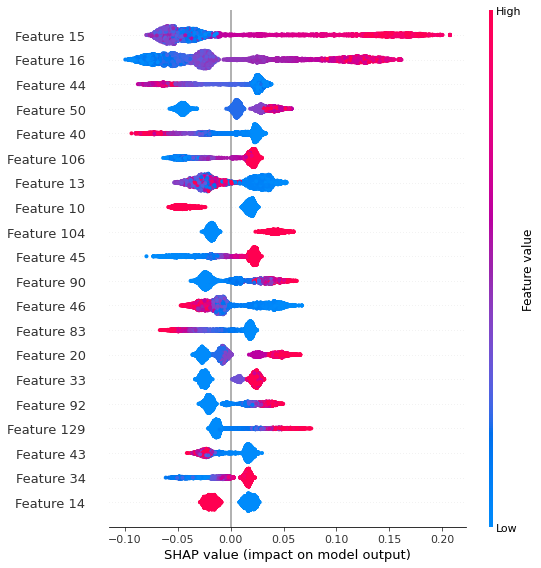

In [42]:
shap.summary_plot(shap_values, select_X_train)

# SVM (Support Vector Machine):

## GridSearch 

In [43]:
'''
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
gridsearch(xgb,param_grid,X_train_os,y_train_os,cv = 8)   
'''

"\nparam_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}\ngridsearch(xgb,param_grid,X_train_os,y_train_os,cv = 8)   \n"

## Final Model & Results

In [44]:
clf = SVC( kernel = 'linear', C = 0.01, probability = True, random_state = 0)
clf.fit(select_X_train, y_train_os)

SVC(C=0.01, kernel='linear', probability=True, random_state=0)

In [45]:
SVM_train = create_dataframe(clf,select_X,y_train,1,4.685249,scale=True)
SVM_test = create_dataframe(clf,select_X_test,y_test,1,4.685249,scale=True)

roc:  0.68155
total_wgt:  4895
total_bad_rate:  0.175893769
KS:  27.005200000000002


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


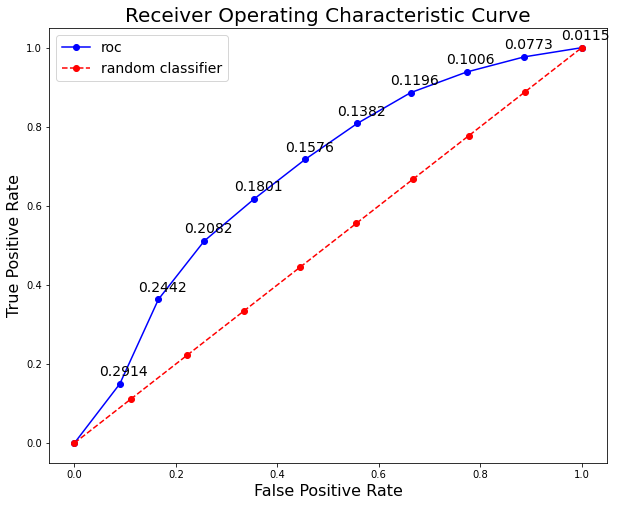

-----------------------------------------------------------------------------------------
------------------------------------TEST-------------------------------------------------
-----------------------------------------------------------------------------------------
roc:  0.6445
total_wgt:  1463
total_bad_rate:  0.175666439
KS:  24.9495


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


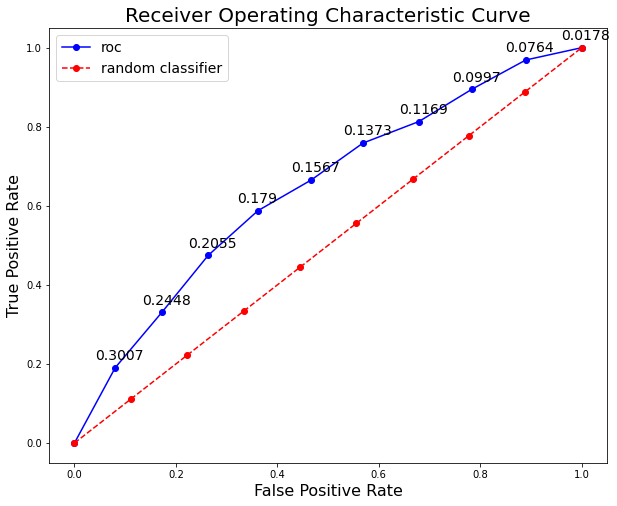

In [46]:
out_SVM_train=calculate_metrics(SVM_train,'bad',1,'model_predicted_probability',10,False)
print('-----------------------------------------------------------------------------------------')
print('------------------------------------TEST-------------------------------------------------')
print('-----------------------------------------------------------------------------------------')
out_SVM_test=calculate_metrics(SVM_test,'bad',1,'model_predicted_probability',10,False)

   ROC-AUC  ROC-AUC as Prob
0  0.63453         0.681548
    ROC-AUC  ROC-AUC as Prob
0  0.609377         0.644503


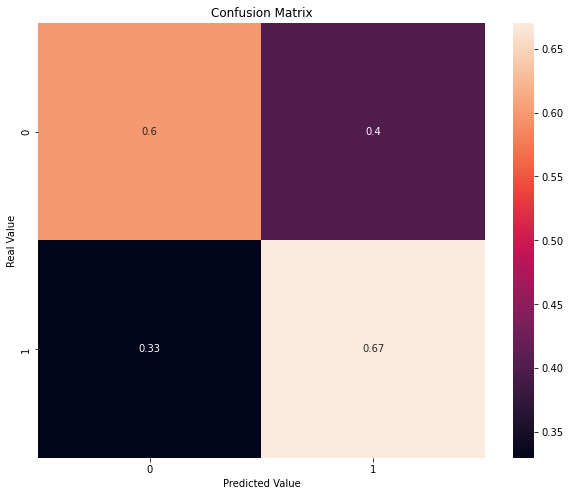

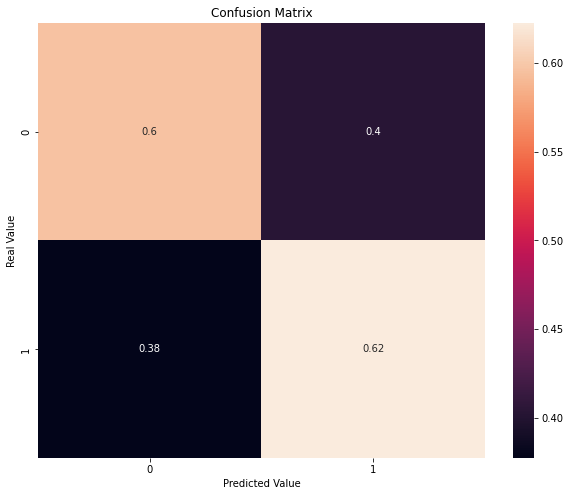

In [47]:
svm_pred_train = confusionmatrix(clf, select_X, y_train)
svm_pred_test = confusionmatrix(clf, select_X_test, y_test)

## Validation

In [48]:
SVM_val = create_dataframe(clf,select_X_val_scaled,y_val,1,4.685249,scale=True)

roc:  0.6337
total_wgt:  1776
total_bad_rate:  0.18018018
KS:  21.5762


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


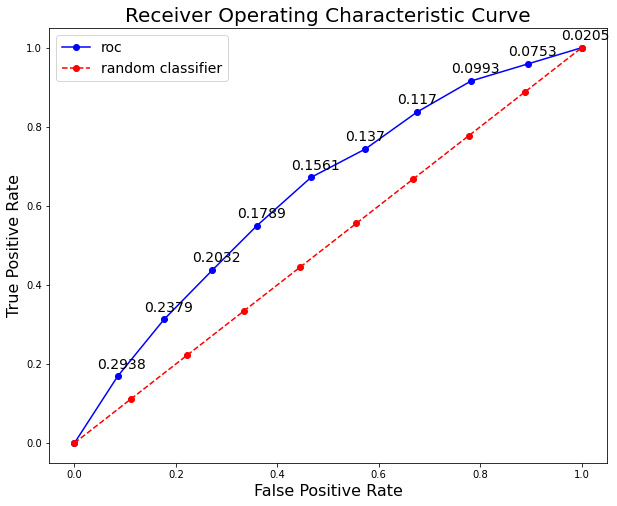

In [49]:
out_SVM_val=calculate_metrics(SVM_val,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.596171         0.633696


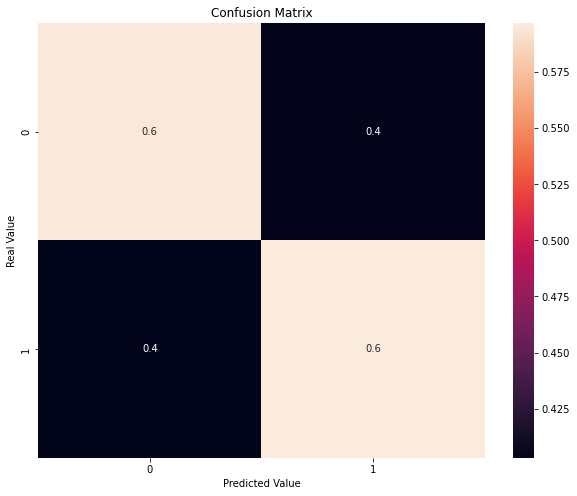

In [50]:
svm_pred_val = confusionmatrix(clf,select_X_val_scaled,y_val)

# CatBoost:

## Final Model & Results

In [51]:
cb = CatBoostClassifier(n_estimators=1500, depth=4,min_data_in_leaf =1,subsample = 0.05, learning_rate=0.003, l2_leaf_reg=10, logging_level='Silent')
cb.fit(select_X_train, y_train_os)

In [52]:
CB_train = create_dataframe(cb,select_X,y_train,1,4.685249,scale=True)
CB_test = create_dataframe(cb,select_X_test,y_test,1,4.685249,scale=True)

roc:  0.74331
total_wgt:  4895
total_bad_rate:  0.175893769
KS:  36.6813


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


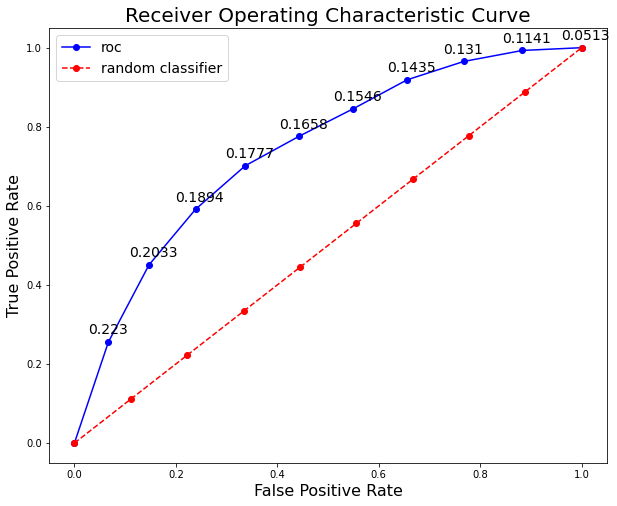

In [53]:
out_CB_train=calculate_metrics(CB_train,'bad',1,'model_predicted_probability',10,False)

roc:  0.6446
total_wgt:  1463
total_bad_rate:  0.175666439
KS:  24.458099999999998


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


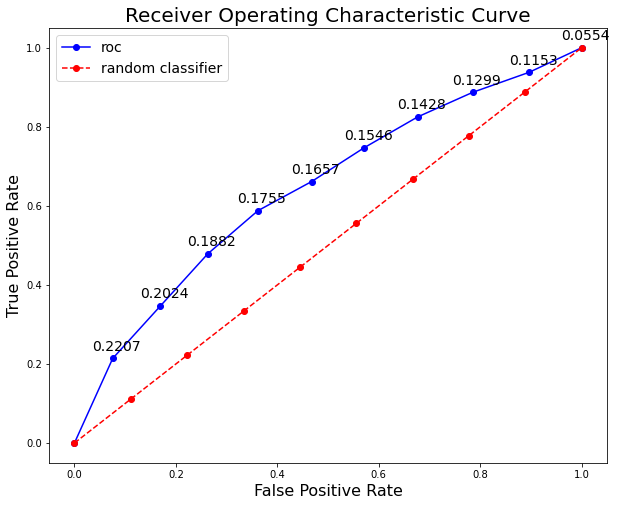

In [54]:
out_CB_test=calculate_metrics(CB_test,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.678738         0.743308
    ROC-AUC  ROC-AUC as Prob
0  0.609535         0.644601


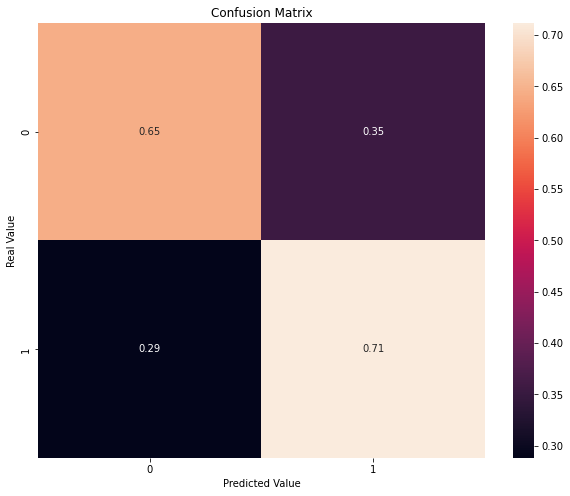

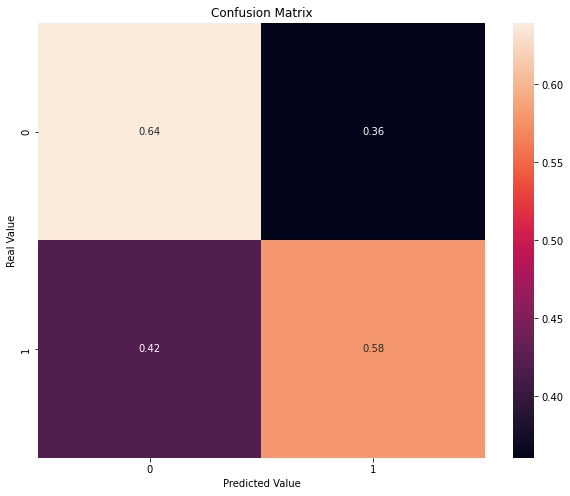

In [55]:
cb_pred_train = confusionmatrix(cb, select_X, y_train)
cb_pred_test = confusionmatrix(cb, select_X_test, y_test)

## Validation

In [56]:
CB_val = create_dataframe(cb,select_X_val_scaled,y_val,1,4.685249,scale=True)

roc:  0.62293
total_wgt:  1776
total_bad_rate:  0.18018018
KS:  19.2926


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


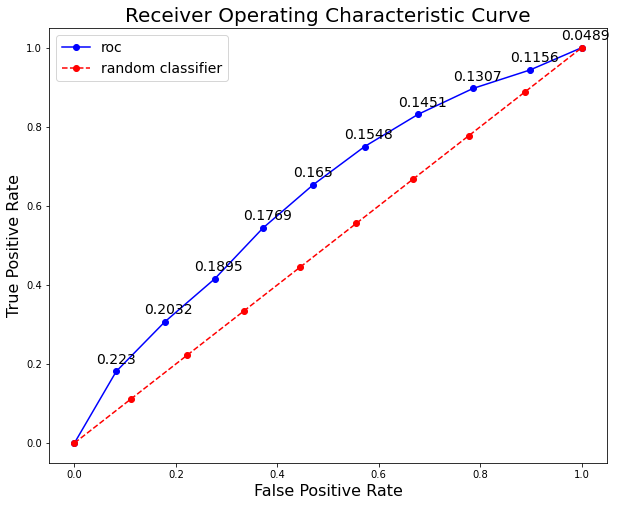

In [57]:
out_CB_val=calculate_metrics(CB_val,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.591157          0.62293


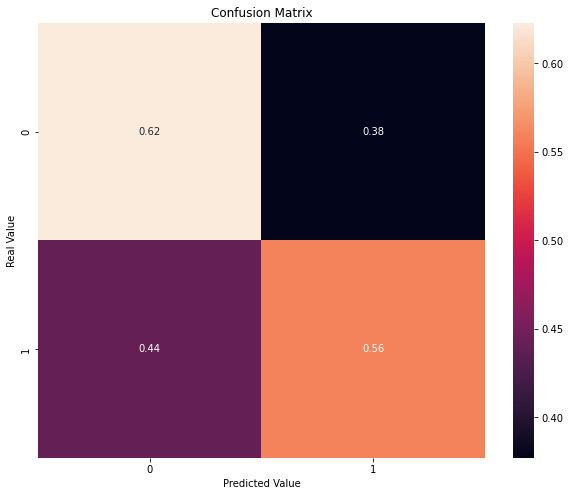

In [59]:
cb_pred_val = confusionmatrix(cb,select_X_val_scaled,y_val)

# Neural Network:

## Final Model & Results

In [60]:
tf.keras.utils.set_random_seed(0) 
np.random.seed(0)
input_neurons = X_train_os.shape[1]
output_neurons = 1
layersnumber_of_hidden_layers = 6
neuron_hidden_layer_1         = 60
neuron_hidden_layer_2         = 40
neuron_hidden_layer_3        = 30

In [61]:
tf.keras.utils.set_random_seed(0) 
np.random.seed(0)
model = Sequential()
model.add(InputLayer(input_shape=(input_neurons)))
model.add(Dense(units=neuron_hidden_layer_1,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=neuron_hidden_layer_2, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=neuron_hidden_layer_3, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=output_neurons, activation='sigmoid'))

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                17040     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [63]:
tf.keras.utils.set_random_seed(0) 
np.random.seed(0)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), 
 loss= 'binary_crossentropy' ,
 metrics= [ tf.keras.metrics.AUC(),tf.keras.metrics.TrueNegatives()]) 
model.fit(X_train_os, y_train_os, batch_size = 20, epochs=50, validation_split = 0.15, validation_batch_size= 15, verbose = 1)
model.save('my_model')

Epoch 1/50
343/343 [==============================] - 2s 4ms/step - loss: 0.7082 - auc: 0.5205 - true_negatives: 3061.0000 - val_loss: 1.0331 - val_auc: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 2/50
343/343 [==============================] - 1s 2ms/step - loss: 0.6789 - auc: 0.5432 - true_negatives: 3566.0000 - val_loss: 0.7964 - val_auc: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 3/50
343/343 [==============================] - 1s 2ms/step - loss: 0.6696 - auc: 0.5765 - true_negatives: 3714.0000 - val_loss: 0.9262 - val_auc: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 4/50
343/343 [==============================] - 1s 2ms/step - loss: 0.6675 - auc: 0.5799 - true_negatives: 3777.0000 - val_loss: 0.8916 - val_auc: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 5/50
343/343 [==============================] - 1s 2ms/step - loss: 0.6644 - auc: 0.5889 - true_negatives: 3775.0000 - val_loss: 0.8021 - val_auc: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 6/50
343/

In [64]:
NN_train = create_dataframe(model,X_train_scaled,y_train,1,4.685249,scale=True,neural = True)
NN_test = create_dataframe(model,X_test_scaled,y_test,1,4.685249,scale=True, neural = True)

roc:  0.68726
total_wgt:  4895
total_bad_rate:  0.175893769
KS:  28.938999999999997


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


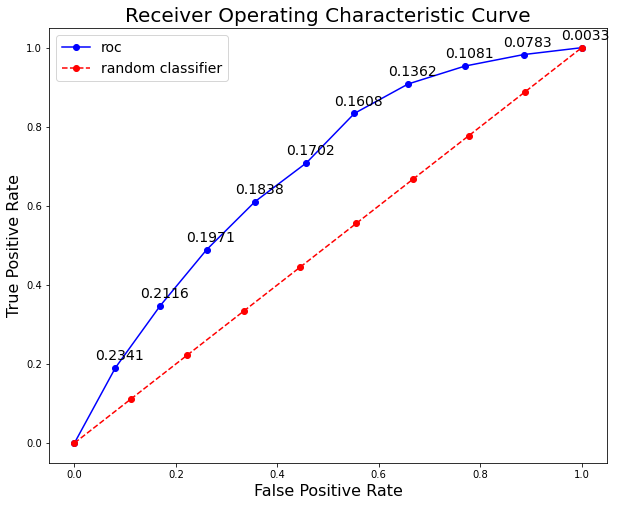

-----------------------------------------------------------------------------------------
------------------------------------TEST-------------------------------------------------
-----------------------------------------------------------------------------------------
roc:  0.59833
total_wgt:  1463
total_bad_rate:  0.175666439
KS:  17.078699999999998


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


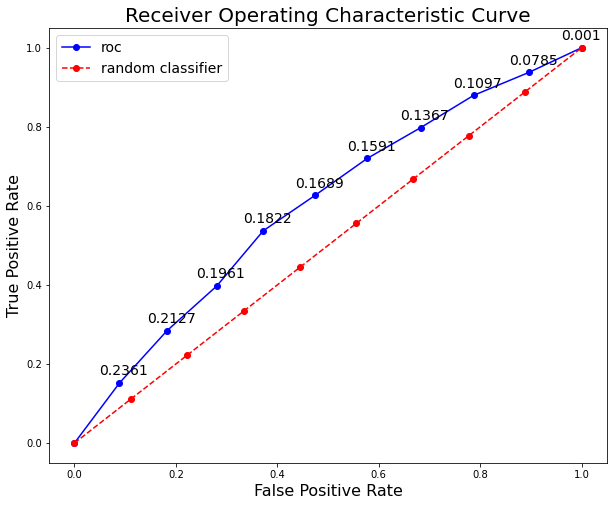

In [65]:
out_NN_train=calculate_metrics(NN_train,'bad',1,'model_predicted_probability',10,False)
print('-----------------------------------------------------------------------------------------')
print('------------------------------------TEST-------------------------------------------------')
print('-----------------------------------------------------------------------------------------')
out_NN_test=calculate_metrics(NN_test,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.628039         0.687262
    ROC-AUC  ROC-AUC as Prob
0  0.579971         0.598328


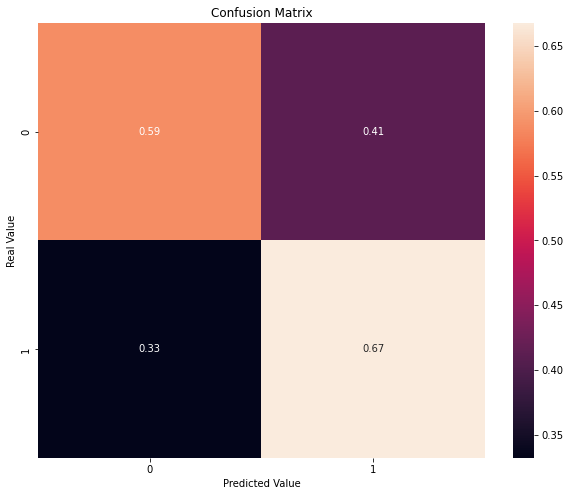

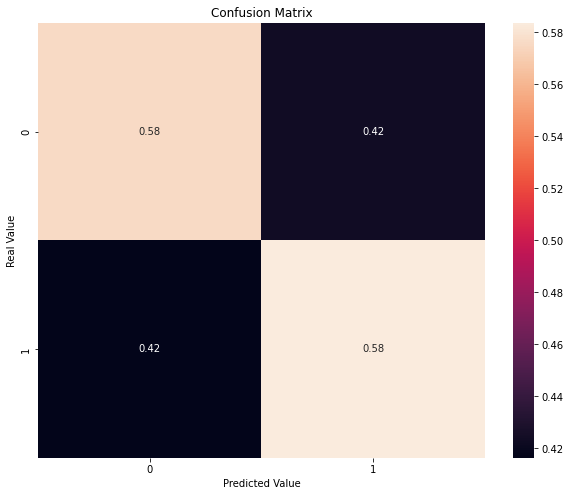

In [66]:
nn_pred_train = confusionmatrix(model, X_train_scaled, y_train,neural = True)
nn_pred_test = confusionmatrix(model, X_test_scaled, y_test, neural = True)

## Validation

In [67]:
NN_val = create_dataframe(model,X_val_scaled,y_val,1,4.685249,scale=True,neural = True)

roc:  0.57635
total_wgt:  1776
total_bad_rate:  0.18018018
KS:  12.5962


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


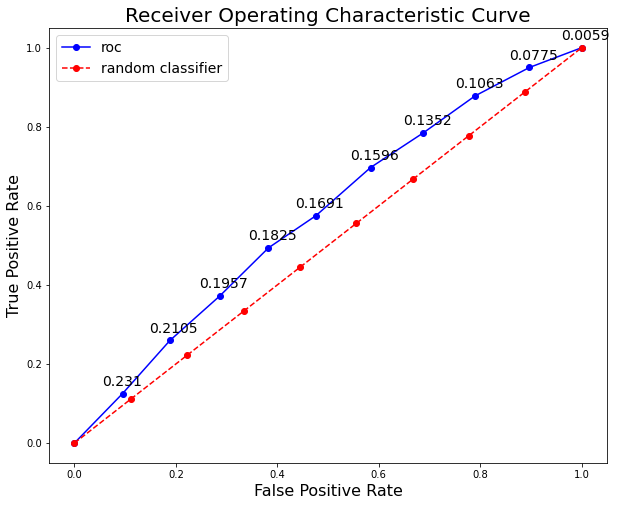

In [68]:
out_NN_val=calculate_metrics(NN_val,'bad',1,'model_predicted_probability',10,False)

    ROC-AUC  ROC-AUC as Prob
0  0.555529         0.576349


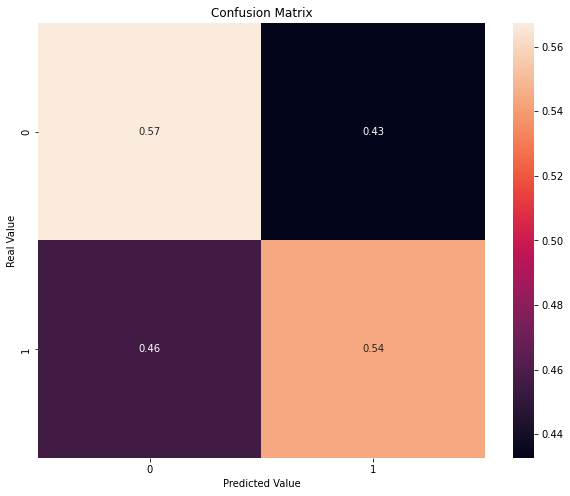

In [69]:
nn_pred_val = confusionmatrix(model, X_val_scaled, y_val, neural = True)

# Comparing Models:


## Rank Order Tables

**XGBoost (Extreme Gradient Boosting):**

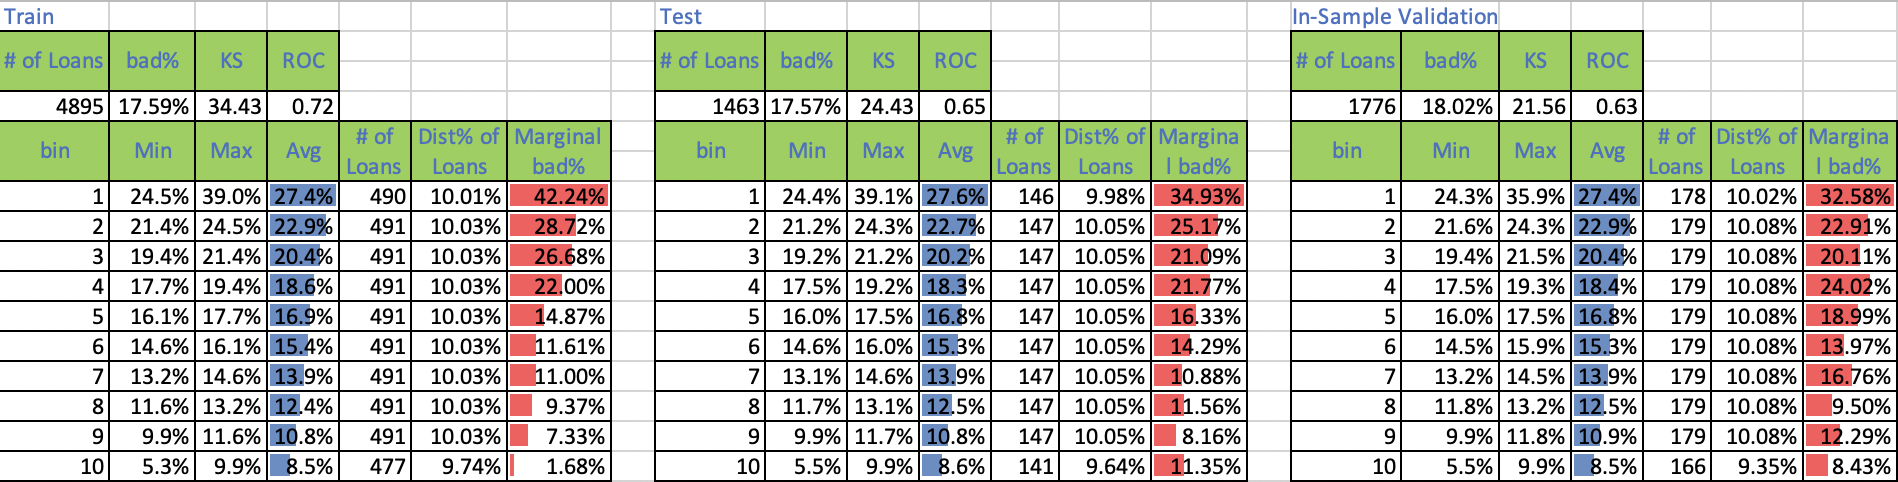

**SVM (Support Vector Machine):**

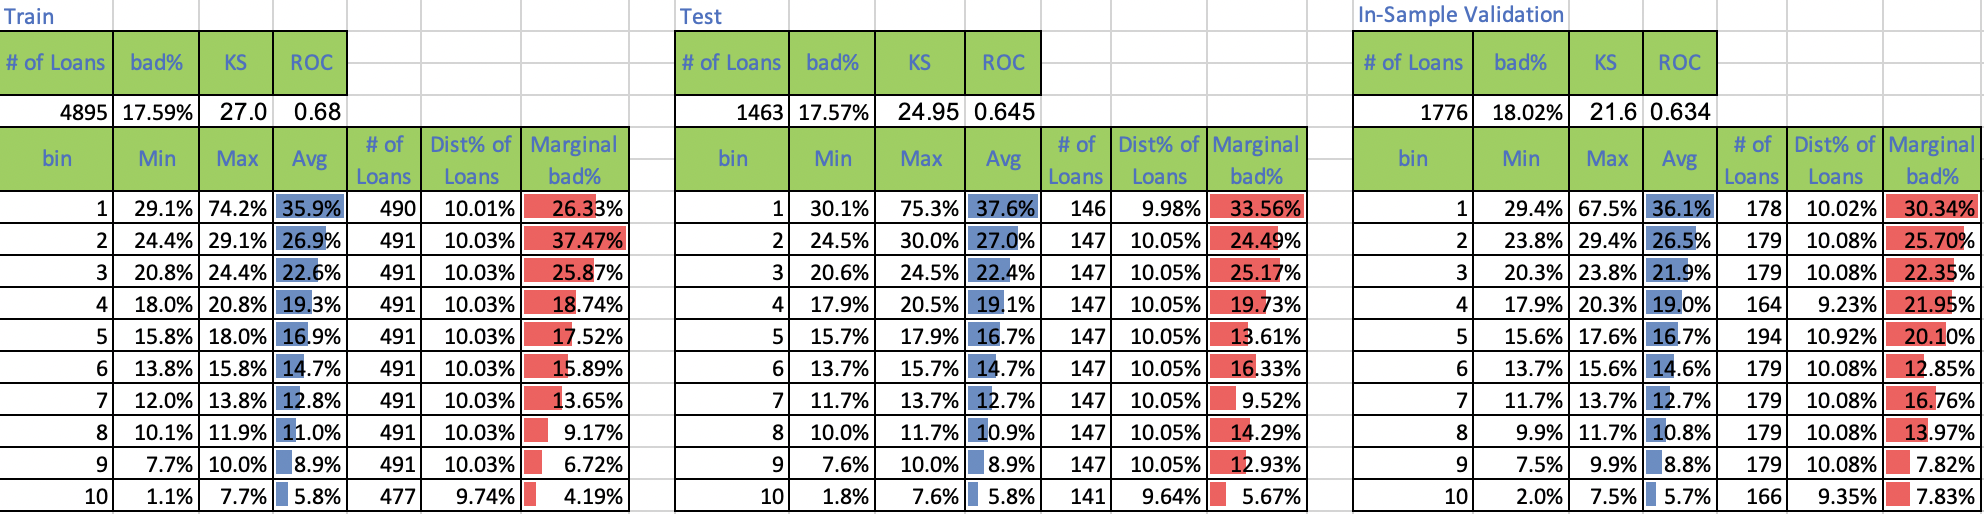

**CatBoost:**

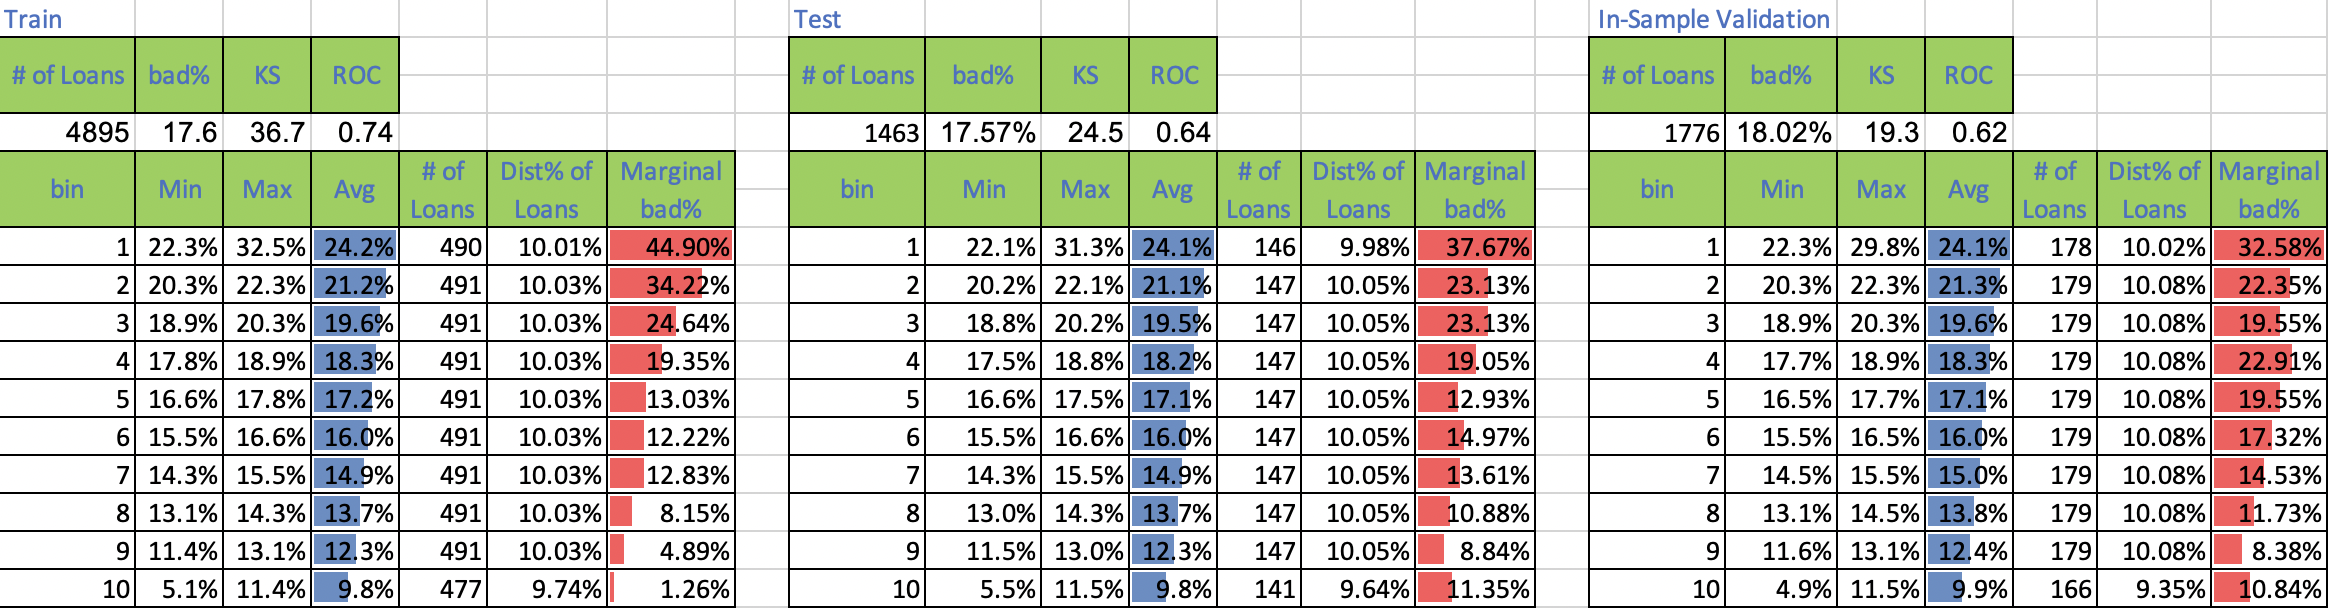

**Artifical Neural Network:**

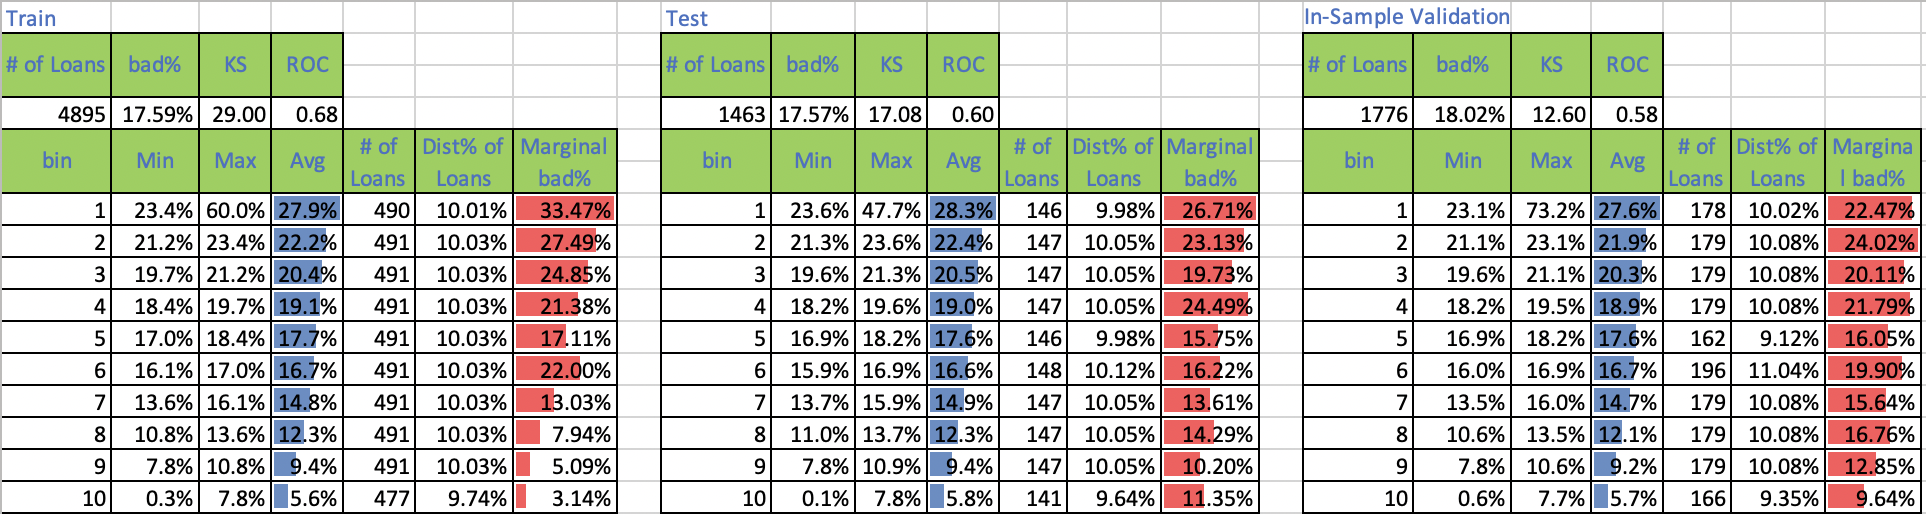

## ROC-Curve for All Models:

**Train Data:**

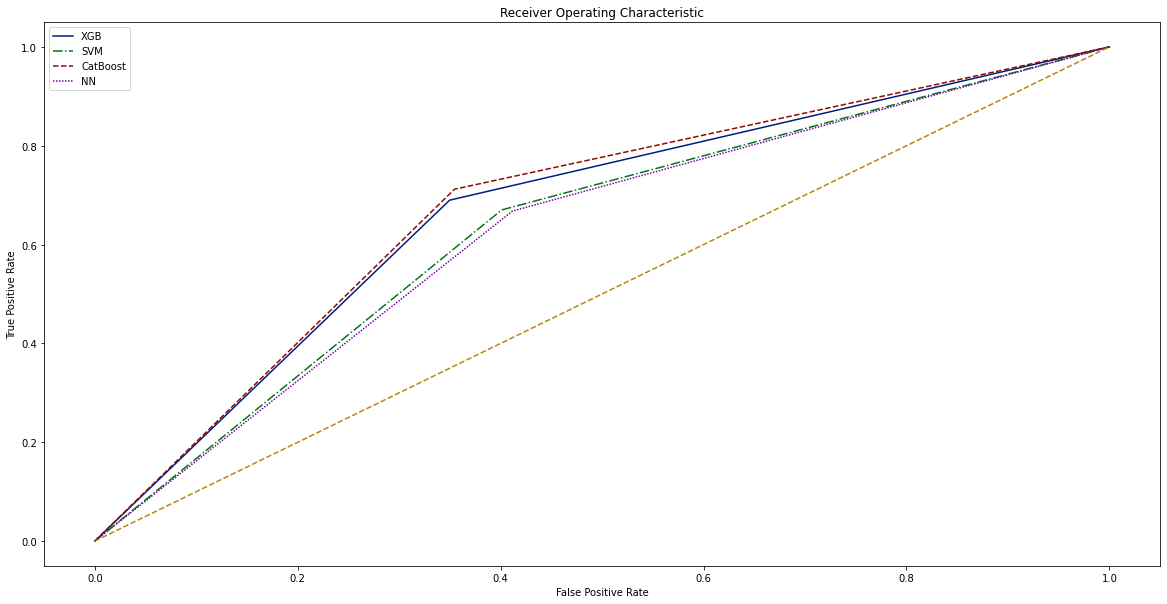

In [72]:
# ROC Curve
false_positive_rate1, true_positive_rate1, _ = roc_curve(y_train, xgb_pred_train)
false_positive_rate2, true_positive_rate2, _ = roc_curve(y_train, svm_pred_train)
false_positive_rate3, true_positive_rate3, _ = roc_curve(y_train, cb_pred_train)
false_positive_rate4, true_positive_rate4, _ = roc_curve(y_train, nn_pred_train)
plt.subplots(1, figsize=(20,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1,linestyle='solid')
plt.plot(false_positive_rate2, true_positive_rate2,linestyle='dashdot')
plt.plot(false_positive_rate3, true_positive_rate3,linestyle='dashed')
plt.plot(false_positive_rate4, true_positive_rate4,linestyle=(0, (1, 1)))
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["XGB", "SVM","CatBoost","NN"], loc=0, frameon=True)
plt.show()

**Test Data**:

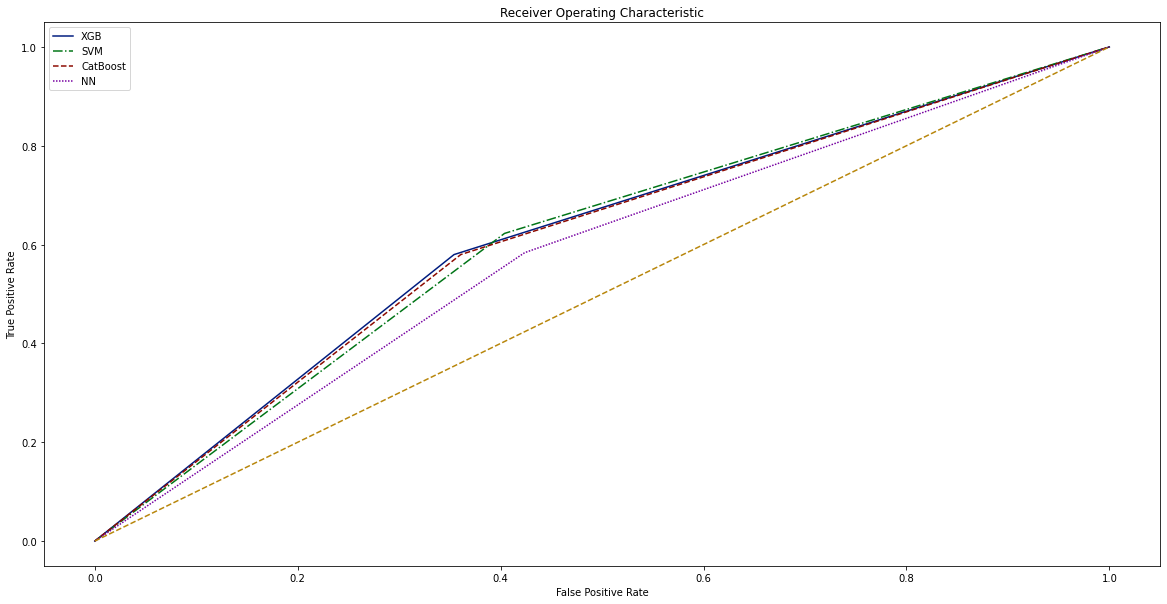

In [74]:
# ROC Curve
false_positive_rate1, true_positive_rate1, _ = roc_curve(y_test, xgb_pred_test)
false_positive_rate2, true_positive_rate2, _ = roc_curve(y_test, svm_pred_test)
false_positive_rate3, true_positive_rate3, _ = roc_curve(y_test, cb_pred_test)
false_positive_rate4, true_positive_rate4, _ = roc_curve(y_test, nn_pred_test)
plt.subplots(1, figsize=(20,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1,linestyle='solid')
plt.plot(false_positive_rate2, true_positive_rate2,linestyle='dashdot')
plt.plot(false_positive_rate3, true_positive_rate3,linestyle='dashed')
plt.plot(false_positive_rate4, true_positive_rate4,linestyle=(0, (1, 1)))
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["XGB", "SVM","CatBoost","NN"], loc=0, frameon=True)
plt.show()

**Validation Data**

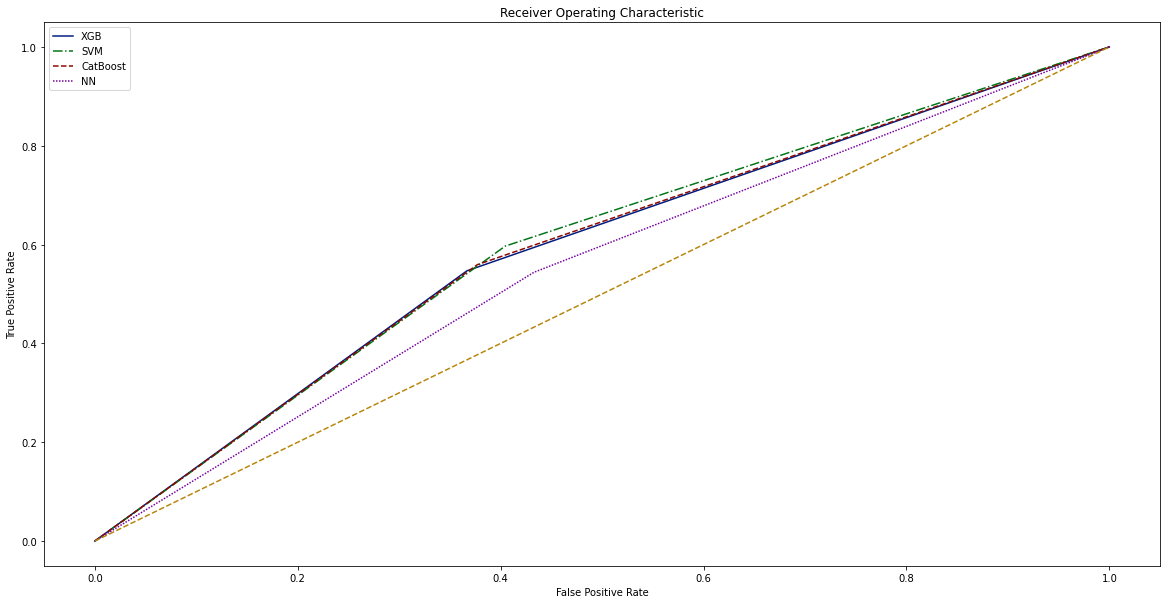

In [75]:
# ROC Curve
false_positive_rate1, true_positive_rate1, _ = roc_curve(y_val, xgb_pred_val)
false_positive_rate2, true_positive_rate2, _ = roc_curve(y_val, svm_pred_val)
false_positive_rate3, true_positive_rate3, _ = roc_curve(y_val, cb_pred_val)
false_positive_rate4, true_positive_rate4, _ = roc_curve(y_val, nn_pred_val)
plt.subplots(1, figsize=(20,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1,linestyle='solid')
plt.plot(false_positive_rate2, true_positive_rate2,linestyle='dashdot')
plt.plot(false_positive_rate3, true_positive_rate3,linestyle='dashed')
plt.plot(false_positive_rate4, true_positive_rate4,linestyle=(0, (1, 1)))
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["XGB", "SVM","CatBoost","NN"], loc=0, frameon=True)
plt.show()

## Swap Set Analysis:

In [76]:
df1 = scorecard(clf,cb,select_X_val_scaled,y_val)

------------------------------------------------------------------
Swap-IN Size: 171
Swap-OUT Size 143
Swap IN / Swap OUT: 1.1958041958041958
Swap OUT / Swap IN: 0.8362573099415205
------------------------------------------------------------------
Swap-IN-Positive: 29
Swap-IN-Negative: 142
Swap-OUT-Positive: 41
Swap-OUT-Negative: 102
------------------------------------------------------------------
Approved by Both: 865
Declined by Both: 597
Approved by First, Declined By Second: 131
Declined by First, Approved By Second: 183


In [78]:
df3 = scorecard(cb,xgb,select_X_val_scaled,y_val)

------------------------------------------------------------------
Swap-IN Size: 50
Swap-OUT Size 39
Swap IN / Swap OUT: 1.2820512820512822
Swap OUT / Swap IN: 0.78
------------------------------------------------------------------
Swap-IN-Positive: 7
Swap-IN-Negative: 43
Swap-OUT-Positive: 11
Swap-OUT-Negative: 28
------------------------------------------------------------------
Approved by Both: 1013
Declined by Both: 674
Approved by First, Declined By Second: 35
Declined by First, Approved By Second: 54


**One of Swap Set Analysis Comparison:**

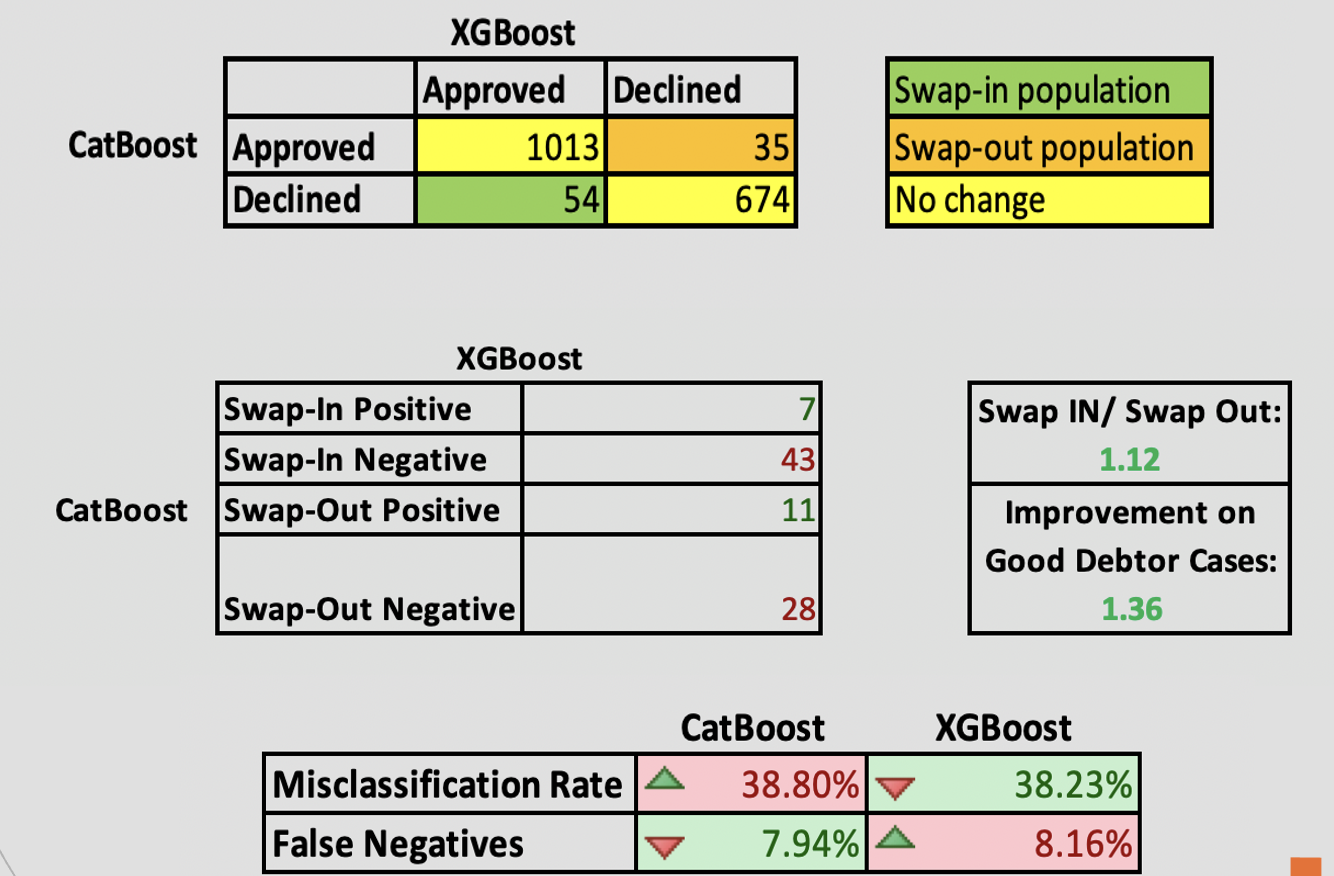